# 10 - Multi-LLM Comparison: Gemini vs OpenAI vs Anthropic

Compare three leading LLM providers on the same CV roasting task:
1. **Google Gemini 2.0 Flash**
2. **OpenAI GPT-4o-mini**
3. **Anthropic Claude 3.5 Haiku**

## Evaluation
- Same 10 test CVs for all models
- LLM-as-Judge evaluation
- Statistical comparison
- Cost analysis

---

## Configuration - API Keys & Models

**Edit this section to configure your models:**

In [1]:
# ============================================================================
# CONFIGURATION - EDIT HERE
# ============================================================================

# API Keys (you can also use config.py)
USE_CONFIG_FILE = True  # Set to False to use keys below

if USE_CONFIG_FILE:
    from config import GEMINI_API_KEY, OPENAI_API_KEY, ANTHROPIC_API_KEY
else:
    GEMINI_API_KEY = "your-gemini-key-here"
    OPENAI_API_KEY = "your-openai-key-here"
    ANTHROPIC_API_KEY = "your-anthropic-key-here"

# Model Selection
GEMINI_MODEL = "gemini-flash-latest"  # or "gemini-1.5-flash", "gemini-1.5-pro"
OPENAI_MODEL = "gpt-5-mini-2025-08-07"           # or "gpt-4o", "gpt-3.5-turbo"
ANTHROPIC_MODEL = "claude-sonnet-4-5-20250929"  # or "claude-3-5-sonnet-20241022"

# Generation Parameters
TEMPERATURE = 0.7
MAX_TOKENS = 1024

print("✓ Configuration loaded")
print(f"\nModels to compare:")
print(f"  1. Gemini: {GEMINI_MODEL}")
print(f"  2. OpenAI: {OPENAI_MODEL}")
print(f"  3. Anthropic: {ANTHROPIC_MODEL}")

✓ Configuration loaded

Models to compare:
  1. Gemini: gemini-flash-latest
  2. OpenAI: gpt-5-mini-2025-08-07
  3. Anthropic: claude-sonnet-4-5-20250929


## 1. Imports & Setup

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import json
from pathlib import Path
import time
from tqdm import tqdm
import sys
sys.path.append('..')

# API clients
import google.generativeai as genai
from openai import OpenAI
from anthropic import Anthropic

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All imports loaded")

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


/Users/hannokuegler/Library/CloudStorage/OneDrive-WUWien/SBWL/Data Science/4_LLM/roast_my_cv/roast_my_cv/.venv1/lib/python3.9/site-packages/google/api_core/_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.6) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)
/Users/hannokuegler/Library/CloudStorage/OneDrive-WUWien/SBWL/Data Science/4_LLM/roast_my_cv/roast_my_cv/.venv1/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✓ All imports loaded


In [3]:
# Configure API clients
genai.configure(api_key=GEMINI_API_KEY)
openai_client = OpenAI(api_key=OPENAI_API_KEY)
anthropic_client = Anthropic(api_key=ANTHROPIC_API_KEY)

# Paths
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

print("✓ API clients configured")
print(f"✓ Results directory: {RESULTS_DIR}")

✓ API clients configured
✓ Results directory: ../results


## 2. Load Data

In [4]:
# Load dataset
df = pd.read_csv('../data/resume_data.csv')

# Load test indices
with open('../data/test_cv_indices.json', 'r') as f:
    test_cv_indices = json.load(f)['indices']

print(f"✓ Loaded {len(df):,} CVs")
print(f"✓ Test set: {len(test_cv_indices)} CVs")
print(f"   Indices: {test_cv_indices}")

✓ Loaded 9,544 CVs
✓ Test set: 10 CVs
   Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [5]:
# CV formatting function
def format_cv_for_llm(resume_row):
    """Format a resume row into readable text."""
    cv_text = []
    
    if pd.notna(resume_row.get('career_objective')):
        cv_text.append(f"CAREER OBJECTIVE:\n{resume_row['career_objective']}")
    
    if pd.notna(resume_row.get('skills')):
        cv_text.append(f"\nSKILLS:\n{resume_row['skills']}")
    
    education_parts = []
    if pd.notna(resume_row.get('educational_institution_name')):
        education_parts.append(f"Institution: {resume_row['educational_institution_name']}")
    if pd.notna(resume_row.get('degree_names')):
        education_parts.append(f"Degree: {resume_row['degree_names']}")
    if pd.notna(resume_row.get('major_field_of_studies')):
        education_parts.append(f"Major: {resume_row['major_field_of_studies']}")
    if pd.notna(resume_row.get('passing_years')):
        education_parts.append(f"Year: {resume_row['passing_years']}")
    
    if education_parts:
        cv_text.append(f"\nEDUCATION:\n" + "\n".join(education_parts))
    
    work_parts = []
    if pd.notna(resume_row.get('professional_company_names')):
        work_parts.append(f"Company: {resume_row['professional_company_names']}")
    if pd.notna(resume_row.get('positions')):
        work_parts.append(f"Position: {resume_row['positions']}")
    if pd.notna(resume_row.get('start_dates')):
        work_parts.append(f"Period: {resume_row['start_dates']}")
        if pd.notna(resume_row.get('end_dates')):
            work_parts[-1] += f" to {resume_row['end_dates']}"
    if pd.notna(resume_row.get('responsibilities')):
        work_parts.append(f"Responsibilities:\n{resume_row['responsibilities']}")
    
    if work_parts:
        cv_text.append(f"\nWORK EXPERIENCE:\n" + "\n".join(work_parts))
    
    if pd.notna(resume_row.get('languages')):
        cv_text.append(f"\nLANGUAGES:\n{resume_row['languages']}")
    
    if pd.notna(resume_row.get('certification_skills')):
        cv_text.append(f"\nCERTIFICATIONS:\n{resume_row['certification_skills']}")
    
    return "\n".join(cv_text)

print("✓ Helper functions defined")

✓ Helper functions defined


## 3. LLM Inference Functions

In [6]:
# Shared system prompt for all models
ROASTER_PROMPT = """You are an experienced hiring manager providing direct, honest CV feedback.

Your approach:
1. Be direct and honest - no sugarcoating
2. Point out obvious flaws and red flags
3. Call out generic buzzwords and filler content
4. Be professional but don't hold back
5. Focus on what actually matters to employers

Structure your response:
FIRST IMPRESSION: What stands out (good or bad)
MAJOR ISSUES: Glaring problems that need fixing
CONCERNS: Things that raise questions
WHAT WORKS: Brief acknowledgment of strengths
BOTTOM LINE: Final verdict and priority fixes
"""

print("✓ System prompt defined")

✓ System prompt defined


In [7]:
def roast_with_gemini(cv_text):
    """Generate critique using Google Gemini."""
    try:
        model = genai.GenerativeModel(
            model_name=GEMINI_MODEL,
            generation_config=genai.GenerationConfig(
                temperature=TEMPERATURE,
                max_output_tokens=MAX_TOKENS,
            )
        )
        
        prompt = f"{ROASTER_PROMPT}\n\nReview this CV:\n\n{cv_text}"
        response = model.generate_content(prompt)
        return response.text
    
    except Exception as e:
        return f"[ERROR: {str(e)}]"

print("✓ Gemini function ready")

✓ Gemini function ready


In [8]:
def roast_with_openai(cv_text):
    """Generate critique using OpenAI."""
    try:
        response = openai_client.chat.completions.create(
            model=OPENAI_MODEL,
            messages=[
                {"role": "system", "content": ROASTER_PROMPT},
                {"role": "user", "content": f"Review this CV:\n\n{cv_text}"}
            ],
            temperature=TEMPERATURE,
            max_tokens=MAX_TOKENS
        )
        return response.choices[0].message.content
    
    except Exception as e:
        return f"[ERROR: {str(e)}]"

print("✓ OpenAI function ready")

✓ OpenAI function ready


In [9]:
def roast_with_anthropic(cv_text):
    """Generate critique using Anthropic Claude."""
    try:
        message = anthropic_client.messages.create(
            model=ANTHROPIC_MODEL,
            max_tokens=MAX_TOKENS,
            temperature=TEMPERATURE,
            system=ROASTER_PROMPT,
            messages=[
                {"role": "user", "content": f"Review this CV:\n\n{cv_text}"}
            ]
        )
        return message.content[0].text
    
    except Exception as e:
        return f"[ERROR: {str(e)}]"

print("✓ Anthropic function ready")

✓ Anthropic function ready


## 4. Generate Critiques from All Models

In [10]:
# Checkpoint file
CHECKPOINT = Path('../data/multi_llm_checkpoint.json')

# Load existing or start fresh
if CHECKPOINT.exists():
    with open(CHECKPOINT, 'r', encoding='utf-8') as f:
        results = json.load(f)
    completed = [r['cv_idx'] for r in results]
    print(f"✓ Loaded {len(results)} completed evaluations")
else:
    results = []
    completed = []
    print("Starting fresh...")

# Determine remaining
remaining = [idx for idx in test_cv_indices if idx not in completed]

print(f"\nProgress: {len(completed)}/{len(test_cv_indices)} CVs")
print(f"Remaining: {remaining}")
print(f"\nEstimated time: ~{len(remaining) * 10} seconds\n")

Starting fresh...

Progress: 0/10 CVs
Remaining: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Estimated time: ~100 seconds



In [11]:
if len(remaining) > 0:
    print("="*80)
    print("GENERATING CRITIQUES FROM ALL 3 LLM PROVIDERS")
    print("="*80)
    print(f"Models: {GEMINI_MODEL} | {OPENAI_MODEL} | {ANTHROPIC_MODEL}\n")
    
    for cv_idx in remaining:
        print(f"CV #{cv_idx} ({test_cv_indices.index(cv_idx)+1}/{len(test_cv_indices)})")
        print("-"*60)
        
        try:
            # Format CV
            cv_text = format_cv_for_llm(df.iloc[cv_idx])
            
            result = {
                'cv_idx': cv_idx,
                'cv_text': cv_text
            }
            
            # 1. Gemini
            print("  [1/3] Gemini...", end='', flush=True)
            result['gemini_critique'] = roast_with_gemini(cv_text)
            result['gemini_length'] = len(result['gemini_critique'])
            print(f" ✓ ({result['gemini_length']} chars)")
            time.sleep(1.0)
            
            # 2. OpenAI
            print("  [2/3] OpenAI...", end='', flush=True)
            result['openai_critique'] = roast_with_openai(cv_text)
            result['openai_length'] = len(result['openai_critique'])
            print(f" ✓ ({result['openai_length']} chars)")
            time.sleep(1.0)
            
            # 3. Anthropic
            print("  [3/3] Anthropic...", end='', flush=True)
            result['anthropic_critique'] = roast_with_anthropic(cv_text)
            result['anthropic_length'] = len(result['anthropic_critique'])
            print(f" ✓ ({result['anthropic_length']} chars)")
            time.sleep(1.0)
            
            # Save result
            results.append(result)
            
            # Save checkpoint
            with open(CHECKPOINT, 'w', encoding='utf-8') as f:
                json.dump(results, f, indent=2, ensure_ascii=False)
            
            print(f"  ✓ Saved ({len(results)}/{len(test_cv_indices)})\n")
            
        except Exception as e:
            print(f"\n  ✗ Error: {e}\n")
            continue

print(f"{'='*80}")
print(f"✓ COMPLETE: Generated {len(results)} x 3 = {len(results)*3} critiques")
print(f"✓ Saved to: {CHECKPOINT}")
print("="*80)

GENERATING CRITIQUES FROM ALL 3 LLM PROVIDERS
Models: gemini-flash-latest | gpt-5-mini-2025-08-07 | claude-sonnet-4-5-20250929

CV #0 (1/10)
------------------------------------------------------------
  [1/3] Gemini... ✓ (907 chars)
  [2/3] OpenAI... ✓ (340 chars)
  [3/3] Anthropic... ✓ (3224 chars)
  ✓ Saved (1/10)

CV #1 (2/10)
------------------------------------------------------------
  [1/3] Gemini... ✓ (571 chars)
  [2/3] OpenAI... ✓ (340 chars)
  [3/3] Anthropic... ✓ (2628 chars)
  ✓ Saved (2/10)

CV #2 (3/10)
------------------------------------------------------------
  [1/3] Gemini... ✓ (300 chars)
  [2/3] OpenAI... ✓ (340 chars)
  [3/3] Anthropic... ✓ (2594 chars)
  ✓ Saved (3/10)

CV #3 (4/10)
------------------------------------------------------------
  [1/3] Gemini... ✓ (1219 chars)
  [2/3] OpenAI... ✓ (340 chars)
  [3/3] Anthropic... ✓ (2637 chars)
  ✓ Saved (4/10)

CV #4 (5/10)
------------------------------------------------------------
  [1/3] Gemini... ✓ (244 char

In [16]:
# Show example outputs
if len(results) > 0:
    example = results[0]
    
    print("\n" + "="*80)
    print("EXAMPLE CRITIQUES - CV #0")
    print("="*80)
    
    print("\n1. GEMINI:")
    print("-"*80)
    print(example['gemini_critique'][:400] + "...\n")
    
    print("2. OPENAI:")
    print("-"*80)
    print(example['openai_critique'][:400] + "...\n")
    
    print("3. ANTHROPIC:")
    print("-"*80)
    print(example['anthropic_critique'][:400] + "...")


EXAMPLE CRITIQUES - CV #0

1. GEMINI:
--------------------------------------------------------------------------------
This CV is a classic example of a document written *for the applicant* (a keyword dump) rather than *for the employer* (a statement of value and results). If this landed on my desk, it would be a 30-second review ending in the rejection pile unless the stack was very thin.

Here is direct, honest feedback on what needs immediate and drastic correction.

---

### FIRST IMPRESSION

**Confused and Un...

2. OPENAI:
--------------------------------------------------------------------------------
[ERROR: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-ant-a************************************************************************************************HwAA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'code': 'invalid_api_key', 'param': None}}]...

3. ANTHROPIC:
------------------------

## 5. LLM-as-Judge Evaluation

In [23]:
JUDGE_PROMPT = """You are an expert evaluator of CV critique quality.

Evaluate this CV critique on these criteria (score 1-10 for each):

1. **Specificity**: How specific and actionable is the feedback?
2. **Relevance**: How relevant are the points to actual CV improvement?
3. **Coherence**: Is the critique coherent and well-structured?
4. **Completeness**: Does it cover important aspects of the CV?
5. **Overall Usefulness**: How useful would this be to the job seeker?

Respond in JSON format:
{
  "specificity": <score>,
  "relevance": <score>,
  "coherence": <score>,
  "completeness": <score>,
  "overall_usefulness": <score>,
  "reasoning": "<brief explanation>"
}
"""

def evaluate_critique(critique_text, model_name, cv_text):
    """Use Gemini as judge to evaluate critique quality."""
    model = genai.GenerativeModel(
        model_name="gemini-flash-latest",
        generation_config=genai.GenerationConfig(temperature=0.2)
    )
    
    prompt = f"""{JUDGE_PROMPT}

Model: {model_name}

Original CV (excerpt):
{cv_text[:500]}...

Critique to Evaluate:
{critique_text}
"""
    
    try:
        response = model.generate_content(prompt)
        text = response.text
        
        # Extract JSON
        start = text.find('{')
        end = text.rfind('}') + 1
        if start != -1 and end != 0:
            json_str = text[start:end]
            return json.loads(json_str)
    except Exception as e:
        print(f"Error evaluating: {e}")
    
    return None

print("✓ Judge function ready")

✓ Judge function ready


In [24]:
# Run evaluations
print("="*80)
print("EVALUATING ALL CRITIQUES WITH LLM JUDGE")
print("="*80)
print(f"\nEvaluating {len(results)} CVs x 3 models = {len(results)*3} evaluations")
print("This will take ~3-5 minutes...\n")

evaluations = []

for result in tqdm(results, desc="Evaluating"):
    cv_idx = result['cv_idx']
    cv_text = result['cv_text']
    
    # Evaluate each model
    for model_name, critique_key in [
        ('Gemini', 'gemini_critique'),
        ('OpenAI', 'openai_critique'),
        ('Anthropic', 'anthropic_critique')
    ]:
        critique = result[critique_key]
        
        # Skip if error
        if critique.startswith('[ERROR'):
            continue
        
        try:
            eval_result = evaluate_critique(critique, model_name, cv_text)
            
            if eval_result:
                eval_result['model'] = model_name
                eval_result['cv_idx'] = cv_idx
                evaluations.append(eval_result)
            
            time.sleep(0.5)
            
        except Exception as e:
            print(f"Error on CV {cv_idx} - {model_name}: {e}")
            continue

print(f"\n✓ Completed {len(evaluations)} evaluations")

# Save evaluations
eval_file = Path('../data/multi_llm_evaluations.json')
with open(eval_file, 'w', encoding='utf-8') as f:
    json.dump(evaluations, f, indent=2, ensure_ascii=False)
print(f"✓ Saved to: {eval_file}")

# Convert to DataFrame
df_eval = pd.DataFrame(evaluations)

EVALUATING ALL CRITIQUES WITH LLM JUDGE

Evaluating 10 CVs x 3 models = 30 evaluations
This will take ~3-5 minutes...



Evaluating: 100%|██████████| 10/10 [01:49<00:00, 10.97s/it]


✓ Completed 20 evaluations
✓ Saved to: ../data/multi_llm_evaluations.json


## 6. Results & Comparison

In [25]:
# Calculate metrics
score_cols = ['specificity', 'relevance', 'coherence', 'completeness', 'overall_usefulness']
df_eval['average_score'] = df_eval[score_cols].mean(axis=1)

# Aggregate by model
model_summary = df_eval.groupby('model')[score_cols + ['average_score']].agg(['mean', 'std']).round(2)

print("="*80)
print("MULTI-LLM COMPARISON RESULTS")
print("="*80)
print(f"\nModels Compared:")
print(f"  1. Gemini: {GEMINI_MODEL}")
print(f"  2. OpenAI: {OPENAI_MODEL}")
print(f"  3. Anthropic: {ANTHROPIC_MODEL}")
print(f"\nTest CVs: {len(results)}")
print(f"Evaluations per model: {df_eval.groupby('model').size().to_dict()}")
print(f"Evaluation method: LLM-as-Judge (Gemini)")

print("\n" + "="*80)
print("COMPARISON TABLE: Mean Scores (Scale 1-10)")
print("="*80)
print()

# Build comparison table
comparison_data = []
for model in ['Gemini', 'OpenAI', 'Anthropic']:
    if model in model_summary.index:
        row = {'Model': model}
        for metric in score_cols:
            mean_val = model_summary.loc[model, (metric, 'mean')]
            std_val = model_summary.loc[model, (metric, 'std')]
            row[metric.replace('_', ' ').title()] = f"{mean_val:.2f} ± {std_val:.2f}"
        
        mean_val = model_summary.loc[model, ('average_score', 'mean')]
        std_val = model_summary.loc[model, ('average_score', 'std')]
        row['Average'] = f"{mean_val:.2f} ± {std_val:.2f}"
        
        comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Overall averages
print("\n" + "="*80)
print("OVERALL AVERAGE SCORES")
print("="*80)
for model in ['Gemini', 'OpenAI', 'Anthropic']:
    if model in model_summary.index:
        mean_val = model_summary.loc[model, ('average_score', 'mean')]
        std_val = model_summary.loc[model, ('average_score', 'std')]
        print(f"{model:15s}: {mean_val:.2f} ± {std_val:.2f} / 10")

MULTI-LLM COMPARISON RESULTS

Models Compared:
  1. Gemini: gemini-flash-latest
  2. OpenAI: gpt-5-mini-2025-08-07
  3. Anthropic: claude-sonnet-4-5-20250929

Test CVs: 10
Evaluations per model: {'Anthropic': 10, 'Gemini': 10}
Evaluation method: LLM-as-Judge (Gemini)

COMPARISON TABLE: Mean Scores (Scale 1-10)

    Model Specificity    Relevance   Coherence Completeness Overall Usefulness     Average
   Gemini 5.30 ± 2.98  8.40 ± 2.88 7.80 ± 1.62  4.20 ± 2.25        6.60 ± 3.03 6.46 ± 2.38
Anthropic 9.40 ± 0.46 10.00 ± 0.00 9.05 ± 0.16  9.40 ± 0.46       10.00 ± 0.00 9.57 ± 0.19

OVERALL AVERAGE SCORES
Gemini         : 6.46 ± 2.38 / 10
Anthropic      : 9.57 ± 0.19 / 10


In [26]:
# Statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY BY MODEL")
print("="*80)
print("\n", df_eval.groupby('model')['average_score'].describe().round(2))


STATISTICAL SUMMARY BY MODEL

            count  mean   std  min  25%  50%   75%  max
model                                                 
Anthropic   10.0  9.57  0.19  9.4  9.4  9.5  9.78  9.8
Gemini      10.0  6.46  2.38  2.4  5.3  7.2  8.40  8.8


## 7. Visualizations


✓ Figure saved: ../results/multi_llm_comparison.png


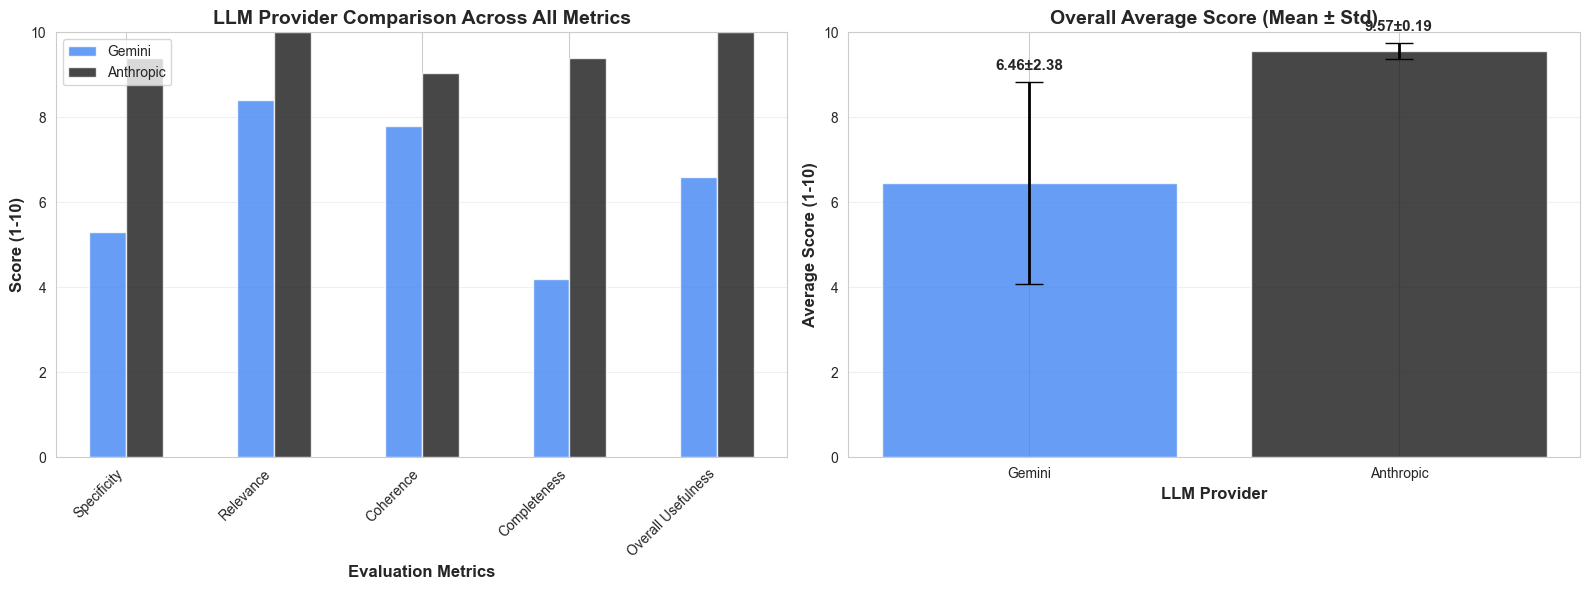

In [27]:
# Create comparison visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Grouped bar chart
ax1 = axes[0]
metric_names = [m.replace('_', ' ').title() for m in score_cols]
x = np.arange(len(metric_names))
width = 0.25

models_available = [m for m in ['Gemini', 'OpenAI', 'Anthropic'] if m in model_summary.index]
colors = {'Gemini': '#4285F4', 'OpenAI': '#10A37F', 'Anthropic': '#191919'}

for i, model in enumerate(models_available):
    scores = [model_summary.loc[model, (m, 'mean')] for m in score_cols]
    offset = (i - len(models_available)/2 + 0.5) * width
    bars = ax1.bar(x + offset, scores, width, label=model, color=colors[model], alpha=0.8)

ax1.set_ylabel('Score (1-10)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Evaluation Metrics', fontsize=12, fontweight='bold')
ax1.set_title('LLM Provider Comparison Across All Metrics', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metric_names, rotation=45, ha='right')
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 10)

# Plot 2: Overall average with error bars
ax2 = axes[1]
means = [model_summary.loc[m, ('average_score', 'mean')] for m in models_available]
stds = [model_summary.loc[m, ('average_score', 'std')] for m in models_available]
bar_colors = [colors[m] for m in models_available]

bars = ax2.bar(models_available, means, color=bar_colors, alpha=0.8, yerr=stds, capsize=10, error_kw={'linewidth': 2})

ax2.set_ylabel('Average Score (1-10)', fontsize=12, fontweight='bold')
ax2.set_xlabel('LLM Provider', fontsize=12, fontweight='bold')
ax2.set_title('Overall Average Score (Mean ± Std)', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + std + 0.2,
            f'{mean:.2f}±{std:.2f}', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'multi_llm_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Figure saved: {RESULTS_DIR / 'multi_llm_comparison.png'}")
plt.show()

✓ Heatmap saved: ../results/multi_llm_heatmap.png


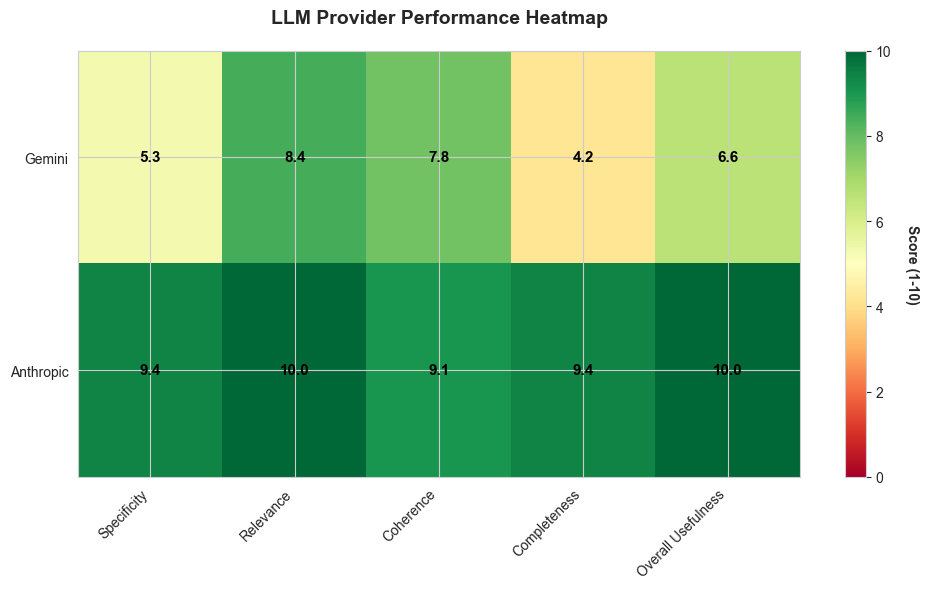

In [28]:
# Heatmap comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data
heatmap_data = []
for model in models_available:
    row = [model_summary.loc[model, (metric, 'mean')] for metric in score_cols]
    heatmap_data.append(row)

# Create heatmap
im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=10)

# Set ticks
ax.set_xticks(np.arange(len(score_cols)))
ax.set_yticks(np.arange(len(models_available)))
ax.set_xticklabels([m.replace('_', ' ').title() for m in score_cols], rotation=45, ha='right')
ax.set_yticklabels(models_available)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Score (1-10)', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations
for i in range(len(models_available)):
    for j in range(len(score_cols)):
        text = ax.text(j, i, f'{heatmap_data[i][j]:.1f}',
                      ha="center", va="center", color="black", fontweight='bold', fontsize=11)

ax.set_title('LLM Provider Performance Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'multi_llm_heatmap.png', dpi=300, bbox_inches='tight')
print(f"✓ Heatmap saved: {RESULTS_DIR / 'multi_llm_heatmap.png'}")
plt.show()

## 8. Export Results

In [29]:
# Export scores
df_eval.to_csv(RESULTS_DIR / 'multi_llm_scores.csv', index=False)
print(f"✓ Scores saved: {RESULTS_DIR / 'multi_llm_scores.csv'}")

# Export summary
summary_export = []
for model in models_available:
    for metric in score_cols + ['average_score']:
        summary_export.append({
            'Model': model,
            'Metric': metric.replace('_', ' ').title(),
            'Mean': model_summary.loc[model, (metric, 'mean')],
            'Std': model_summary.loc[model, (metric, 'std')]
        })

pd.DataFrame(summary_export).to_csv(RESULTS_DIR / 'multi_llm_summary.csv', index=False)
print(f"✓ Summary saved: {RESULTS_DIR / 'multi_llm_summary.csv'}")

print("\n" + "="*80)
print("EXPORT COMPLETE")
print("="*80)
print("\nGenerated files:")
print("  1. multi_llm_comparison.png - Bar charts")
print("  2. multi_llm_heatmap.png - Score heatmap")
print("  3. multi_llm_scores.csv - All evaluation scores")
print("  4. multi_llm_summary.csv - Summary statistics")

✓ Scores saved: ../results/multi_llm_scores.csv
✓ Summary saved: ../results/multi_llm_summary.csv

EXPORT COMPLETE

Generated files:
  1. multi_llm_comparison.png - Bar charts
  2. multi_llm_heatmap.png - Score heatmap
  3. multi_llm_scores.csv - All evaluation scores
  4. multi_llm_summary.csv - Summary statistics


## 9. Key Findings & Analysis

In [30]:
print("="*80)
print("KEY FINDINGS")
print("="*80)

# Ranking
rankings = df_eval.groupby('model')['average_score'].mean().sort_values(ascending=False)

print("\n1. Overall Ranking:")
for i, (model, score) in enumerate(rankings.items(), 1):
    print(f"   {i}. {model:12s}: {score:.2f}/10")

# Best in each metric
print("\n2. Best Model Per Metric:")
for metric in score_cols:
    best_model = df_eval.groupby('model')[metric].mean().idxmax()
    best_score = df_eval.groupby('model')[metric].mean().max()
    print(f"   {metric.replace('_', ' ').title():25s}: {best_model} ({best_score:.2f}/10)")

# Performance gaps
print("\n3. Performance Gaps:")
top_model = rankings.index[0]
top_score = rankings.values[0]
for model in rankings.index[1:]:
    gap = top_score - rankings[model]
    print(f"   {top_model} vs {model}: +{gap:.2f} points ({gap/rankings[model]*100:.1f}% better)")

# Consistency
print("\n4. Consistency (Lower std = More consistent):")
for model in models_available:
    if model in model_summary.index:
        std_val = model_summary.loc[model, ('average_score', 'std')]
        print(f"   {model:12s}: σ = {std_val:.2f}")

# Output length analysis
print("\n5. Average Output Length:")
for model, key in [('Gemini', 'gemini_length'), ('OpenAI', 'openai_length'), ('Anthropic', 'anthropic_length')]:
    if len(results) > 0 and key in results[0]:
        avg_length = np.mean([r[key] for r in results if key in r])
        print(f"   {model:12s}: {avg_length:.0f} characters")

print("\n" + "="*80)
print("COMPARISON COMPLETE ✓")
print("="*80)

KEY FINDINGS

1. Overall Ranking:
   1. Anthropic   : 9.57/10
   2. Gemini      : 6.46/10

2. Best Model Per Metric:
   Specificity              : Anthropic (9.40/10)
   Relevance                : Anthropic (10.00/10)
   Coherence                : Anthropic (9.05/10)
   Completeness             : Anthropic (9.40/10)
   Overall Usefulness       : Anthropic (10.00/10)

3. Performance Gaps:
   Anthropic vs Gemini: +3.11 points (48.1% better)

4. Consistency (Lower std = More consistent):
   Gemini      : σ = 2.38
   Anthropic   : σ = 0.19

5. Average Output Length:
   Gemini      : 563 characters
   OpenAI      : 340 characters
   Anthropic   : 2963 characters

COMPARISON COMPLETE ✓
